<a href="https://colab.research.google.com/github/AgilAptanaDwiPutra/ProjectMachineLearning/blob/main/Tugas_Machine_Learning_1_Model_Klasik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pelabelan

In [ ]:
import pandas as pd

# 1) Load dataset
file_path = "dataset_detik.xlsx"
df = pd.read_excel(file_path, usecols=["subtitle"])

# 2) Daftar kata kunci untuk masing-masing kategori
keywords = {
    "politik": [
        "presiden", "menteri", "partai", "pemilu", "politik", "dpr", "pilkada",
        "gaza", "palestina", "israel"
    ],
    "teknologi": [
        "aplikasi", "internet", "ai", "artificial", "gadget", "teknologi",
        "software", "hp", "smartphone"
    ],
    "hiburan": [
        "film", "artis", "musik", "konser", "drama", "seleb", "hiburan", "lagu"
    ],
}

# 3) Kata yang memicu kategori 'others' meski cocok dengan kategori lain
keywords_others_priority = ["tewas", "bunuh", "meninggal", "penembakan", "porno"]

# 4) Fungsi penentuan label
def assign_label(text):
    text_lower = str(text).lower()

    # -- aturan prioritas: kalau mengandung kata sensitif -> langsung 'others'
    if any(word in text_lower for word in keywords_others_priority):
        return "others"

    # -- aturan normal berdasarkan kategori
    for label, words in keywords.items():
        if any(word in text_lower for word in words):
            return label

    return "others"

# 5) Terapkan fungsi ke seluruh teks
df["label"] = df["subtitle"].apply(assign_label)

# 6) Simpan hasil
output_path = "hasil_labelling.xlsx"
df.to_excel(output_path, index=False)

print("✅ Pelabelan otomatis selesai berdasarkan kata kunci dan prioritas!")
print(f"Hasil disimpan di: {output_path}")
print(df['label'].value_counts())

✅ Pelabelan otomatis selesai berdasarkan kata kunci dan prioritas!
Hasil disimpan di: hasil_labelling.xlsx
label
others       4298
politik      2943
teknologi    2176
hiburan        62
Name: count, dtype: int64


Tahap 1 EDA

In [ ]:
import re, html, unicodedata
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1) Load data
PATH = "hasil_labelling.xlsx"
df = pd.read_excel(PATH)

print("✅ Data berhasil dimuat")
print(f"- Jumlah baris x kolom: {df.shape[0]} x {df.shape[1]}")
print("- Daftar kolom:")
print(list(df.columns))
print()

# 2) Info tipe data & memory
print("=== INFO DATA ===")
print(df.info(memory_usage="deep"))
print()

# 3) Tinjauan cepat 5 baris acak
print("=== CONTOH DATA (5 baris acak) ===")
print(df.sample(min(5, len(df)), random_state=42))
print()

# 4) Cek missing values
print("=== MISSING VALUES per kolom ===")
mv = df.isna().sum().sort_values(ascending=False)
print(mv[mv > 0] if mv.sum() > 0 else "Tidak ada nilai kosong.")
print()

# 5) Cek duplikasi
print("=== DUPLIKASI ===")
dup_all = df.duplicated().sum()
print(f"Duplikasi baris (seluruh kolom): {dup_all}")
print()

# 6) Identifikasi kolom teks & statistik panjang teks
text_keywords = ["judul", "title", "konten", "isi", "content", "teks", "text", "article", "body", "news"]
text_cols = [c for c in df.columns
             if df[c].dtype == "object" and any(k in c.lower() for k in text_keywords)]

if text_cols:
    print("=== STATISTIK TEKS ===")
    for c in text_cols:
        s = df[c].astype(str).fillna("")
        char_len = s.str.len()
        token_len = s.str.split().map(len)

        print(f"\nKolom teks: '{c}'")
        print(f"- Non-null: {s.ne('').sum()} dari {len(s)}")
        print(f"- Panjang karakter (min/mean/median/max): {char_len.min()} / {char_len.mean():.1f} / {char_len.median()} / {char_len.max()}")
        print(f"- Jumlah kata (min/mean/median/max): {token_len.min()} / {token_len.mean():.1f} / {token_len.median()} / {token_len.max()}")
else:
    print("Tidak terdeteksi kolom teks umum (judul/konten/isi/etc). Cek nama kolom Anda.")
print()

✅ Data berhasil dimuat
- Jumlah baris x kolom: 9479 x 2
- Daftar kolom:
['subtitle', 'label']

=== INFO DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9479 entries, 0 to 9478
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subtitle  9479 non-null   object
 1   label     9479 non-null   object
dtypes: object(2)
memory usage: 2.2 MB
None

=== CONTOH DATA (5 baris acak) ===
                                               subtitle    label
6661  Heru Budi menyebutkan sejauh ini 7 orang petug...   others
5474  Presiden Palestina, Mahmoud Abbas, merespons a...  politik
8402  Seorang remaja laki-laki di Rusia dijuluki pah...  hiburan
6582  Suami Bunga Citra Lestari (BCL), Tiko Pradipta...   others
5402  Pasukan Amerika Serikat (AS) menewaskan seoran...   others

=== MISSING VALUES per kolom ===
Tidak ada nilai kosong.

=== DUPLIKASI ===
Duplikasi baris (seluruh kolom): 58

=== STATISTIK TEKS ===

Kolom teks: 'subtitle

Pre-Processing

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
# PIPELINE PRE-PROCESSING TEKS (Bahasa Indonesia)

def preprocess_subtitle(
    df: pd.DataFrame,
    text_col: str = "subtitle",
    keep_intermediate: bool = True,
    keep_numbers: bool = False
) -> pd.DataFrame:

    if text_col not in df.columns:
        raise ValueError(f"Kolom '{text_col}' tidak ditemukan. Kolom tersedia: {list(df.columns)}")

    # --- util dasar
    def normalize_unicode(s: str) -> str:
        return unicodedata.normalize("NFKC", s)

    URL_PATTERN = re.compile(r"(https?://\S+|www\.\S+)")
    MENTION_HASHTAG = re.compile(r"[@#]\w+")
    NON_LETTERS = re.compile(r"[^a-zA-Z\u00C0-\u024F\u1E00-\u1EFF\s]")
    DIGITS = re.compile(r"\d+")

    def case_folding(s: str) -> str:
        return str(s).lower()

    def cleaning(s: str) -> str:
        s = html.unescape(str(s))
        s = normalize_unicode(s)
        s = URL_PATTERN.sub(" ", s)
        s = MENTION_HASHTAG.sub(" ", s)
        if not keep_numbers:
            s = DIGITS.sub(" ", s)
        s = NON_LETTERS.sub(" ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

    def tokenization(s: str):
        return s.split()

    # siapkan Sastrawi (dengan fallback jika tidak tersedia)
    negations = {"tidak", "bukan", "jangan"}
    try:
        from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
        from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

        stop_factory = StopWordRemoverFactory()
        stopwords = set(stop_factory.get_stop_words())
        stopwords = stopwords - negations

        stemmer = StemmerFactory().create_stemmer()

        def stopword_removal(tokens):
            return [t for t in tokens if t not in stopwords and len(t) > 2]

        def stemming(tokens):
            return [stemmer.stem(t) for t in tokens]

        sastrawi_ok = True
    except Exception as e:
        # fallback sederhana bila Sastrawi tidak tersedia
        def stopword_removal(tokens): return tokens
        def stemming(tokens): return tokens
        sastrawi_ok = False
        print("⚠️ Sastrawi tidak tersedia. Melewati stopword removal & stemming.")
        print("Detail:", e)

    # eksekusi pipeline
    out = df.copy()

    # 1) Case folding
    cf_col = "case_folding"
    out[cf_col] = out[text_col].astype(str).map(case_folding)

    # 2) Cleaning
    cln_col = "cleaning"
    out[cln_col] = out[cf_col].map(cleaning)

    # 3) Tokenization
    tok_col = "tokenization"
    out[tok_col] = out[cln_col].map(tokenization)

    # 4) Stopword removal
    sw_col = "stopword_removal"
    out[sw_col] = out[tok_col].map(stopword_removal)

    # 5) Stemming
    stem_col = "stemming"
    out[stem_col] = out[sw_col].map(stemming)

    # 6) Gabungkan hasil akhir
    out["subtitle_clean"] = out[stem_col].map(lambda toks: " ".join(toks)).str.strip()

    # 7) Bersih akhir: kosong & duplikat
    out = out[out["subtitle_clean"].ne("")].drop_duplicates(subset=["subtitle_clean"]).reset_index(drop=True)

    # buang kolom intermediate jika tidak diminta
    if not keep_intermediate:
        out = out[[c for c in out.columns if c not in {cf_col, cln_col, tok_col, sw_col, stem_col}]]

    # info singkat
    print("✅ Pre-processing selesai.",
          f"\n- Sastrawi aktif: {sastrawi_ok}",
          f"\n- Keep numbers: {keep_numbers}",
          f"\n- Baris akhir: {len(out)}")

    return out

df = preprocess_subtitle(df, text_col="subtitle", keep_intermediate=True, keep_numbers=False)
print(df[["subtitle", "subtitle_clean"]].head(10))


✅ Pre-processing selesai. 
- Sastrawi aktif: True 
- Keep numbers: False 
- Baris akhir: 9415
                                            subtitle  \
0  Presiden AS Donald Trump mengisyaratkan akan a...   
1  Netanyahu menyebut negara Palestina akan menja...   
2  Netanyahu mengambil penerbangan lebih panjang ...   
3  Spanyol akan bergabung dengan Italia dalam men...   
4  Media terkemuka Israel menyoroti pidato Presid...   
5  Perdana Menteri Inggris Keir Starmer, mengumum...   
6  Presiden Suriah Ahmed al-Sharaa mengatakan bah...   
7  Presiden Prancis Emmanuel Macron mengatakan ba...   
8  Inggris akan mengakui negara Palestina setelah...   
9  Netanyahu menyebut serangan terhadap Hamas di ...   

                                      subtitle_clean  
0  presiden donald trump isyarat ada terobos kris...  
1  netanyahu sebut negara palestina jadi bunuh di...  
2  netanyahu ambil terbang lebih panjang new york...  
3  spanyol gabung italia kirim kapal perang lindu...  
4  media muka 

Ekstraksi Fitur

- Bow (Back Of Word)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pickle

def build_bow(
    texts,
    ngram_range=(1,1),
    max_features=None,
    min_df=1,
    max_df=1.0
):
    """
    texts: iterable of preprocessed strings (pakai df['subtitle_clean'])
    return: X (sparse csr), vectorizer
    """
    vec = CountVectorizer(
        lowercase=False,
        token_pattern=r"(?u)\b\w+\b",
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df,
        max_df=max_df
    )
    X = vec.fit_transform(texts)
    return X, vec

# === contoh pemakaian ===
X_bow, bow_vec = build_bow(df["subtitle_clean"])
print("BoW shape:", X_bow.shape)

# fitur (vocabulary)
bow_features = np.array(bow_vec.get_feature_names_out())
print("Contoh fitur:", bow_features[:20])

# simpan jika perlu
with open("bow_vectorizer.pkl", "wb") as f:
    pickle.dump(bow_vec, f)

BoW shape: (9415, 10818)
Contoh fitur: ['aaliyah' 'aam' 'aan' 'aang' 'aaron' 'aba' 'abab' 'abad' 'abadhy' 'abadi'
 'abah' 'abai' 'abal' 'abang' 'abast' 'abbas' 'abbassiyeh' 'abc' 'abdalla'
 'abdelsalam']


- TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pickle

def build_tfidf(
    texts,
    ngram_range=(1,1),
    max_features=None,
    min_df=1,
    max_df=1.0,
    sublinear_tf=True,
    norm="l2"
):
    """
    texts: iterable of preprocessed strings (pakai df['subtitle_clean'])
    return: X (sparse csr), vectorizer
    """
    tfidf = TfidfVectorizer(
        lowercase=False,
        token_pattern=r"(?u)\b\w+\b",
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        sublinear_tf=sublinear_tf,
        norm=norm
    )
    X = tfidf.fit_transform(texts)
    return X, tfidf

# === contoh pemakaian ===
X_tfidf, tfidf_vec = build_tfidf(df["subtitle_clean"])
print("TF-IDF shape:", X_tfidf.shape)

tfidf_features = np.array(tfidf_vec.get_feature_names_out())
print("Contoh fitur:", tfidf_features[:20])

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vec, f)

TF-IDF shape: (9415, 10818)
Contoh fitur: ['aaliyah' 'aam' 'aan' 'aang' 'aaron' 'aba' 'abab' 'abad' 'abadhy' 'abadi'
 'abah' 'abai' 'abal' 'abang' 'abast' 'abbas' 'abbassiyeh' 'abc' 'abdalla'
 'abdelsalam']


- Word Embadding (Word2Vec)

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 42.9 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec
import numpy as np
import pickle

def get_token_sequences(df):
    """
    Ambil urutan token dari kolom 'stemming' (list token).
    Jika tidak ada, pakai split dari 'subtitle_clean'.
    """
    if "stemming" in df.columns:
        # pastikan bertipe list of str
        return df["stemming"].apply(lambda toks: [t for t in toks if isinstance(t, str)]).tolist()
    else:
        return df["subtitle_clean"].apply(lambda s: str(s).split()).tolist()

def train_word2vec(
    sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10,
    seed=42
):
    """
    sentences: list of list of tokens
    return: trained Word2Vec model
    """
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg,             # 1=skip-gram; 0=CBOW
        seed=seed
    )
    model.train(sentences, total_examples=len(sentences), epochs=epochs)
    return model

def doc_average_embedding(tokens, w2v, vector_size):
    """Rata-rata embedding kata yg ada di vocab; jika tidak ada → vektor nol."""
    vecs = [w2v.wv[t] for t in tokens if t in w2v.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def build_doc_embeddings(df, w2v, vector_size=300):
    """
    return: np.ndarray shape (n_docs, vector_size)
    """
    sents = get_token_sequences(df)
    mat = np.vstack([doc_average_embedding(tokens, w2v, vector_size) for tokens in sents])
    return mat

# === contoh pemakaian ===
sentences = get_token_sequences(df)
w2v_model = train_word2vec(
    sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

X_w2v = build_doc_embeddings(df, w2v_model, vector_size=w2v_model.vector_size)
print("Word2Vec doc-emb shape:", X_w2v.shape)

# simpan model & matriks
w2v_model.save("word2vec_subtitle.model")
np.save("doc_embeddings_w2v.npy", X_w2v)

Word2Vec doc-emb shape: (9415, 300)


Model Klasik dan Evaluasi Hasil

In [ ]:
from sklearn.model_selection import train_test_split

# Target (label)
y = df["label"]

# Split data
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bow, y,
    test_size=0.2,        # 20% data untuk uji
    random_state=42,
    stratify=y            # jaga proporsi label
)

print("✅ BoW Split:")
print("Train:", Xb_train.shape, " Test:", Xb_test.shape)

✅ BoW Split:
Train: (7532, 10818)  Test: (1883, 10818)


In [ ]:
from sklearn.model_selection import train_test_split

y = df["label"]

Xt_train, Xt_test, yt_train, yt_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✅ TF-IDF Split:")
print("Train:", Xt_train.shape, " Test:", Xt_test.shape)

✅ TF-IDF Split:
Train: (7532, 10818)  Test: (1883, 10818)


In [ ]:
from sklearn.model_selection import train_test_split

y = df["label"]

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_w2v, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✅ Word2Vec Split:")
print("Train:", Xw_train.shape, " Test:", Xw_test.shape)

✅ Word2Vec Split:
Train: (7532, 300)  Test: (1883, 300)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def evaluate_and_print(y_true, y_pred, title=""):
    print(f"\n=== {title} ===")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("F1-macro :", round(f1_score(y_true, y_pred, average="macro"), 4))
    print(classification_report(y_true, y_pred))


- Algoritma Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_bow = MultinomialNB()
nb_bow.fit(Xb_train, yb_train)
pred_nb_bow = nb_bow.predict(Xb_test)

evaluate_and_print(yb_test, pred_nb_bow, "Naive Bayes (Multinomial) + BoW")


=== Naive Bayes (Multinomial) + BoW ===
Accuracy : 0.7127
F1-macro : 0.5233
              precision    recall  f1-score   support

     hiburan       0.00      0.00      0.00        12
      others       0.76      0.68      0.72       856
     politik       0.71      0.91      0.80       581
   teknologi       0.62      0.54      0.58       434

    accuracy                           0.71      1883
   macro avg       0.52      0.53      0.52      1883
weighted avg       0.71      0.71      0.71      1883



In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_tfidf = MultinomialNB()
nb_tfidf.fit(Xt_train, yt_train)
pred_nb_tfidf = nb_tfidf.predict(Xt_test)

evaluate_and_print(yt_test, pred_nb_tfidf, "Naive Bayes (Multinomial) + TF-IDF")



=== Naive Bayes (Multinomial) + TF-IDF ===
Accuracy : 0.676
F1-macro : 0.4312
              precision    recall  f1-score   support

     hiburan       0.00      0.00      0.00        12
      others       0.64      0.86      0.74       856
     politik       0.72      0.83      0.77       581
   teknologi       0.85      0.13      0.22       434

    accuracy                           0.68      1883
   macro avg       0.55      0.45      0.43      1883
weighted avg       0.71      0.68      0.62      1883



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_w2v = GaussianNB()
nb_w2v.fit(Xw_train, yw_train)
pred_nb_w2v = nb_w2v.predict(Xw_test)

evaluate_and_print(yw_test, pred_nb_w2v, "Naive Bayes (Gaussian) + Word2Vec")



=== Naive Bayes (Gaussian) + Word2Vec ===
Accuracy : 0.5289
F1-macro : 0.4224
              precision    recall  f1-score   support

     hiburan       0.01      0.33      0.03        12
      others       0.73      0.45      0.56       856
     politik       0.67      0.75      0.70       581
   teknologi       0.40      0.39      0.40       434

    accuracy                           0.53      1883
   macro avg       0.45      0.48      0.42      1883
weighted avg       0.63      0.53      0.56      1883



- Algoritma SVM

In [ ]:
from sklearn.svm import LinearSVC

svm_bow = LinearSVC()
svm_bow.fit(Xb_train, yb_train)
pred_svm_bow = svm_bow.predict(Xb_test)

evaluate_and_print(yb_test, pred_svm_bow, "SVM (LinearSVC) + BoW")


=== SVM (LinearSVC) + BoW ===
Accuracy : 0.8433
F1-macro : 0.6891
              precision    recall  f1-score   support

     hiburan       0.50      0.17      0.25        12
      others       0.82      0.86      0.84       856
     politik       0.95      0.94      0.94       581
   teknologi       0.75      0.70      0.72       434

    accuracy                           0.84      1883
   macro avg       0.75      0.67      0.69      1883
weighted avg       0.84      0.84      0.84      1883



In [ ]:
from sklearn.svm import LinearSVC

svm_tfidf = LinearSVC()
svm_tfidf.fit(Xt_train, yt_train)
pred_svm_tfidf = svm_tfidf.predict(Xt_test)

evaluate_and_print(yt_test, pred_svm_tfidf, "SVM (LinearSVC) + TF-IDF")


=== SVM (LinearSVC) + TF-IDF ===
Accuracy : 0.8524
F1-macro : 0.6695
              precision    recall  f1-score   support

     hiburan       1.00      0.08      0.15        12
      others       0.81      0.90      0.85       856
     politik       0.94      0.94      0.94       581
   teknologi       0.82      0.66      0.73       434

    accuracy                           0.85      1883
   macro avg       0.89      0.65      0.67      1883
weighted avg       0.85      0.85      0.85      1883



In [ ]:
from sklearn.svm import LinearSVC

svm_w2v = LinearSVC()
svm_w2v.fit(Xw_train, yw_train)
pred_svm_w2v = svm_w2v.predict(Xw_test)

evaluate_and_print(yw_test, pred_svm_w2v, "SVM (LinearSVC) + Word2Vec")


=== SVM (LinearSVC) + Word2Vec ===
Accuracy : 0.7467
F1-macro : 0.5373
              precision    recall  f1-score   support

     hiburan       0.00      0.00      0.00        12
      others       0.71      0.83      0.76       856
     politik       0.85      0.87      0.86       581
   teknologi       0.67      0.43      0.52       434

    accuracy                           0.75      1883
   macro avg       0.56      0.53      0.54      1883
weighted avg       0.74      0.75      0.73      1883



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Algoritma Random Forest

desify

In [ ]:
from scipy.sparse import issparse

def to_dense(X):
    return X.toarray() if issparse(X) else X

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Xb_train_rf = to_dense(Xb_train)
Xb_test_rf  = to_dense(Xb_test)

rf_bow = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_bow.fit(Xb_train_rf, yb_train)
pred_rf_bow = rf_bow.predict(Xb_test_rf)

evaluate_and_print(yb_test, pred_rf_bow, "Random Forest + BoW (dense)")


=== Random Forest + BoW (dense) ===
Accuracy : 0.8779
F1-macro : 0.6863
              precision    recall  f1-score   support

     hiburan       1.00      0.08      0.15        12
      others       0.82      0.95      0.88       856
     politik       0.94      0.97      0.95       581
   teknologi       0.96      0.62      0.76       434

    accuracy                           0.88      1883
   macro avg       0.93      0.66      0.69      1883
weighted avg       0.89      0.88      0.87      1883



In [ ]:
from sklearn.ensemble import RandomForestClassifier

Xt_train_rf = to_dense(Xt_train)
Xt_test_rf  = to_dense(Xt_test)

rf_tfidf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_tfidf.fit(Xt_train_rf, yt_train)
pred_rf_tfidf = rf_tfidf.predict(Xt_test_rf)

evaluate_and_print(yt_test, pred_rf_tfidf, "Random Forest + TF-IDF (dense)")


=== Random Forest + TF-IDF (dense) ===
Accuracy : 0.8731
F1-macro : 0.6827
              precision    recall  f1-score   support

     hiburan       1.00      0.08      0.15        12
      others       0.82      0.94      0.88       856
     politik       0.92      0.97      0.95       581
   teknologi       0.95      0.62      0.75       434

    accuracy                           0.87      1883
   macro avg       0.92      0.66      0.68      1883
weighted avg       0.88      0.87      0.87      1883



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_w2v = RandomForestClassifier(
    n_estimators=600,   # sedikit lebih besar; dimensi rendah (300)
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf_w2v.fit(Xw_train, yw_train)
pred_rf_w2v = rf_w2v.predict(Xw_test)

evaluate_and_print(yw_test, pred_rf_w2v, "Random Forest + Word2Vec")


=== Random Forest + Word2Vec ===
Accuracy : 0.6819
F1-macro : 0.4633
              precision    recall  f1-score   support

     hiburan       0.00      0.00      0.00        12
      others       0.64      0.83      0.72       856
     politik       0.77      0.81      0.79       581
   teknologi       0.62      0.23      0.34       434

    accuracy                           0.68      1883
   macro avg       0.51      0.47      0.46      1883
weighted avg       0.67      0.68      0.65      1883



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluasi Hasil Confusion Matrix

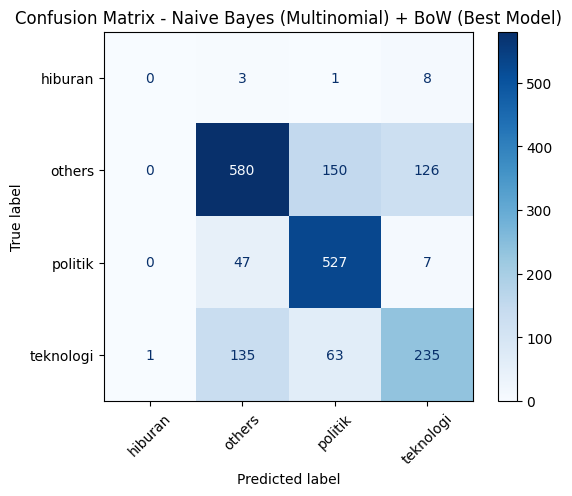

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm_nb_best = confusion_matrix(yb_test, pred_nb_bow, labels=np.unique(yb_test))
disp_nb_best = ConfusionMatrixDisplay(confusion_matrix=cm_nb_best, display_labels=np.unique(yb_test))
disp_nb_best.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Naive Bayes (Multinomial) + BoW (Best Model)")
plt.show()

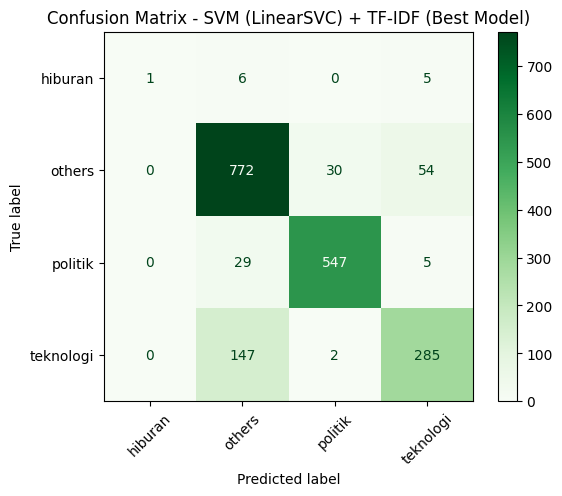

In [ ]:
cm_svm_best = confusion_matrix(yt_test, pred_svm_tfidf, labels=np.unique(yt_test))
disp_svm_best = ConfusionMatrixDisplay(confusion_matrix=cm_svm_best, display_labels=np.unique(yt_test))
disp_svm_best.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - SVM (LinearSVC) + TF-IDF (Best Model)")
plt.show()

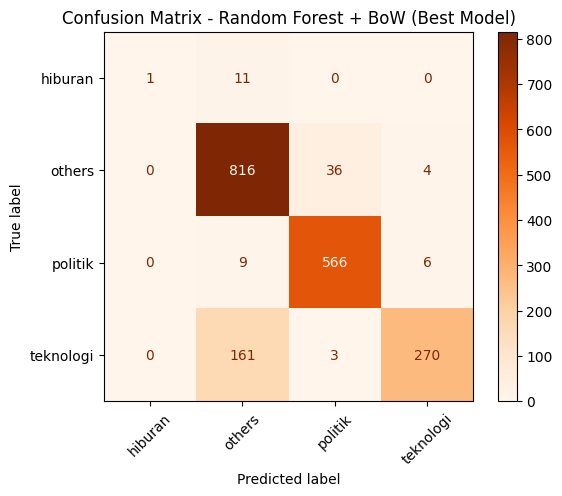

In [ ]:
cm_rf_best = confusion_matrix(yb_test, pred_rf_bow, labels=np.unique(yb_test))
disp_rf_best = ConfusionMatrixDisplay(confusion_matrix=cm_rf_best, display_labels=np.unique(yb_test))
disp_rf_best.plot(cmap='Oranges', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest + BoW (Best Model)")
plt.show()

Distribusi Label:
            Jumlah Data  Persentase (%)
label                                 
others            4298           45.34
politik           2943           31.05
teknologi         2176           22.96
hiburan             62            0.65 



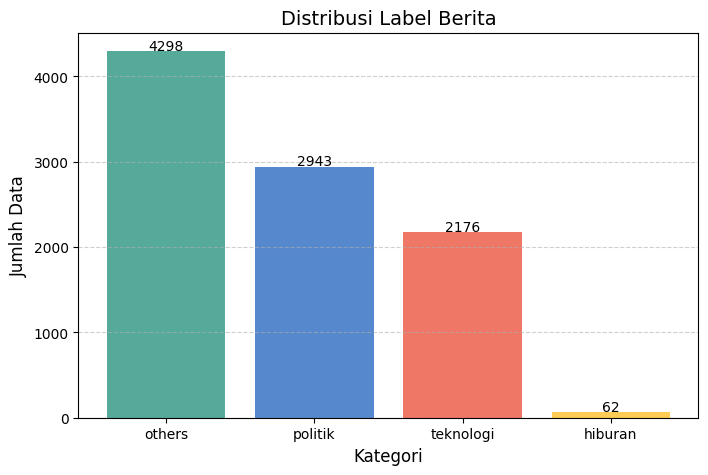

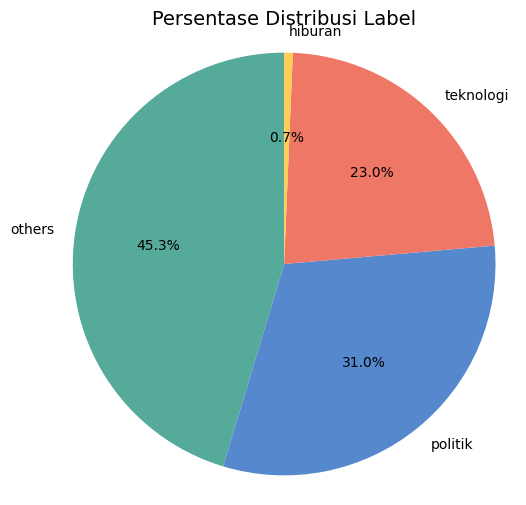

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Baca dataset yang sudah berlabel
file_path = "hasil_labelling.xlsx"
df = pd.read_excel(file_path)

# 2) Hitung distribusi label
label_counts = df["label"].value_counts()
label_percent = df["label"].value_counts(normalize=True) * 100

# 3) Tampilkan tabel distribusi
label_summary = pd.DataFrame({
    "Jumlah Data": label_counts,
    "Persentase (%)": label_percent.round(2)
})
print("Distribusi Label:\n", label_summary, "\n")

# 4) Visualisasi: Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(label_counts.index, label_counts.values, color=['#5A9', '#58C', '#E76', '#FC5'])
plt.title("Distribusi Label Berita", fontsize=14)
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Jumlah Data", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tambahkan nilai di atas batang
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f"{int(bar.get_height())}", ha='center', fontsize=10)

plt.show()

# 5) Visualisasi: Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index,
        autopct='%1.1f%%', startangle=90, colors=['#5A9', '#58C', '#E76', '#FC5'])
plt.title("Persentase Distribusi Label", fontsize=14)
plt.axis("equal")
plt.show()


Fungsi utilitas bersama (split data & builder model RNN)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# --- ambil label ---
y = df["label"].values  # ganti sesuai kolom label
num_classes = len(np.unique(y))

def build_rnn_feature_model(input_dim, num_classes, rnn_units=64, dropout_rate=0.5):
    """
    Model RNN sederhana utk fitur vektor (BoW/TF-IDF/Word2Vec doc embedding)
    Kita treat tiap dokumen sbg sequence dengan 1 time step: shape (1, input_dim)
    """
    model = Sequential([
        tf.keras.layers.Input(shape=(1, input_dim)),
        SimpleRNN(rnn_units),
        Dropout(dropout_rate),
        Dense(64, activation="relu"),
        Dropout(dropout_rate),
        Dense(num_classes, activation="softmax")  # kalau binary → ubah jadi 1 sigmoid
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",  # kalau binary+sigmoid → binary_crossentropy
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

def train_eval_rnn(X, y, test_size=0.2, val_size=0.1, epochs=10, batch_size=64):
    """
    X: np.ndarray 2D (n_samples, n_features)
    y: label 1D
    return: model, history
    """
    # --- split train/test ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )

    # --- split train/val dari train ---
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=val_size,
        random_state=42,
        stratify=y_train
    )

    # --- reshape ke (samples, time_steps=1, features) ---
    X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_rnn   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test_rnn  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = build_rnn_feature_model(input_dim=X.shape[1], num_classes=num_classes)

    history = model.fit(
        X_train_rnn, y_train,
        validation_data=(X_val_rnn, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # --- evaluasi ---
    y_pred_prob = model.predict(X_test_rnn)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print("=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred))
    print("=== CONFUSION MATRIX ===")
    print(confusion_matrix(y_test, y_pred))

    return model, history

- RNN + BoW

In [ ]:
# X_bow dari kode boss sebelumnya
X_bow_dense = X_bow.toarray().astype("float32")
print("BoW dense shape:", X_bow_dense.shape)

model_rnn_bow, history_rnn_bow = train_eval_rnn(X_bow_dense, y)

BoW dense shape: (9415, 10818)


ValueError: Found input variables with inconsistent numbers of samples: [9415, 9479]

- RNN + TF-IDF

- RNN + Word2Vec (doc embedding)